## This is a notebook for training and evaluation of TROCR model


### 1. Installation of required libraries:

In [1]:
## Theses are the must have libraries for trocr

# !pip install -q transformers
# !pip install -q sentencepiece
# !pip install -q jiwer
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q -U accelerate
 
 
# !pip install -q matplotlib
# !pip install -q protobuf==3.20.1
# !pip install -q tensorboard



#### To create required env: open a terminal: ctrl+alt+t 
1. conda create -n trocr python==3.8
2. conda activate trocr
3. pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
4. pip install -r requirements.txt

In [2]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
 
 
from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

/home/frinksserver/anaconda3/envs/trocr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### setting manual seed to reproduce the same results in each run 

def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 
seed_everything(42)
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Folder structure for data
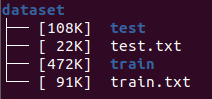

- train.txt annotation format: (img_name)\t(annotation)

- 
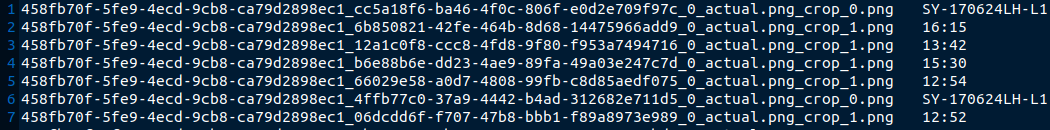


In [7]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 8
    EPOCHS:        int = 100
    LEARNING_RATE: float = 0.0005
 
@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '/home/frinksserver/Deepak/OCR/models/trocr/dataset'
 
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-base-printed' ### for other models: https://huggingface.co/models?search=trocr
    




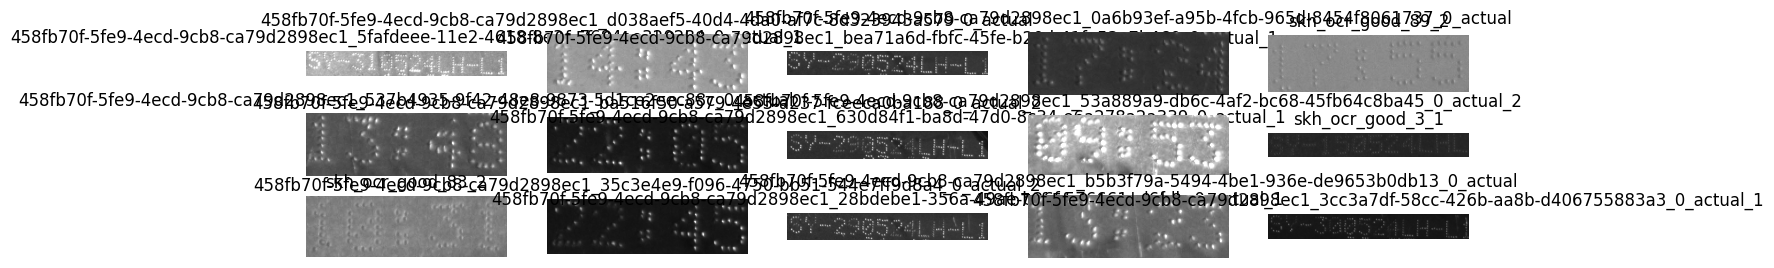

In [8]:
### data visualisation

def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/train")
        image = plt.imread(f"{dataset_path}/train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()
 
 
visualize(DatasetConfig.DATA_ROOT)

### 3. Data preparation:

In [9]:
### creating dataframe using pandas
train_df = pd.read_csv(os.path.join(DatasetConfig.DATA_ROOT, 'train.txt'), sep='\t', header=None)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
train_df.text = train_df.text.astype(str)
test_df = pd.read_csv(os.path.join(DatasetConfig.DATA_ROOT, 'test.txt'), sep='\t', header=None)

test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
test_df.text = test_df.text.astype(str)

In [10]:
train_df.head(10)

,file_name,text
0,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_cc5a18f6-...,SY-170624LH-L1
1,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_6b850821-...,16:15
2,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_12a1c0f8-...,13:42
3,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_b6e88b6e-...,15:30
4,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_66029e58-...,12:54
5,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_4ffb77c0-...,SY-170624LH-L1
6,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_06dcdd6f-...,12:52
7,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_2bec87a7-...,16:26
8,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_119015bd-...,14:08
9,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_4b71f9d4-...,12:05


In [11]:
test_df.head(10)

,file_name,text
0,skh_ocr_good_66_1.png,SY-210524LHL
1,skh_ocr_good_66_2.png,10:18
2,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_1a714a34-...,SY-170624LH-L1
3,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_740765f0-...,17:20
4,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_b3b4b644-...,SY-150624LH-L1
5,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_3d7cce02-...,SY-150624LH-L1
6,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_e52cb886-...,SY-150624LH-L1
7,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_274e48b5-...,16:28
8,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_24c504a2-...,14:53
9,458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_61171ce0-...,SY-160624LH-L1


### 4. Training Setup:

In [12]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.3, hue=.2),
transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [13]:
### Data Loader class:

class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
 
 
    def __len__(self):
        return len(self.df)
 
 
    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [14]:
# loading TrOCRProcessor model
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

### data loader created 
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'test/'),
    df=test_df,
    processor=processor
)

In [15]:
### Loading model & model architecture visualisation

model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

#### 4.1: setting up hyperparameters:

In [16]:

# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id 
 
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
### optimizers 
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [18]:
### CER: Character Error Rate ---> Evaluation metric setup

cer_metric = evaluate.load('cer')
 
 
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
 
 
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
 
 
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
 
 
    return {"cer": cer}

### 5. Training:

In [19]:
### creating training arguments:

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=10,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [20]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/home/frinksserver/anaconda3/envs/trocr/lib/python3.8/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [51]:
### Starting training

res = trainer.train() 

Epoch,Training Loss,Validation Loss,Cer
1,0.049100,0.082329,0.031883
2,0.034600,0.049534,0.046532
3,0.061400,0.090327,0.118053
4,0.034100,0.055473,0.006032
5,0.070200,0.768172,0.135717
6,0.043300,0.051361,0.006894
7,0.026000,0.044092,0.008186
8,0.023000,0.037758,0.011633
9,0.021000,0.058458,0.007755
10,0.012700,0.047560,0.004739


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.

### 6. Model Evaluation:

In [21]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
# trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step),).to(device)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-11880').to(device)

In [22]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.
 
 
    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [24]:
### to run inference:

def ocr(image, processor, model):
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

### 6. Results visualtion and annotation file creation:
This will perform following tasks:
1. read images from a folder or data_path
2. OCR prediction
3. save result image in result_path
4. create and save annotation txt file 

In [23]:
### plot and write into txt file the predictions of trocr in annotation format for further  training
### 
import os
import matplotlib.pyplot as plt

def eval_custom_data(
    data_path="/home/frinksserver/Downloads/synthetic_skh_data/synthetic_data",
    res_name="skh"
):
    image_paths = os.listdir(data_path)
    result_path = f"/home/frinksserver/backup_server3/OCR/models/trocr/val_results/{res_name}"
    os.makedirs(result_path, exist_ok=True)

    predictions_file_path = os.path.join(result_path, f"{res_name}_predictions.txt")
    with open(predictions_file_path, 'w') as predictions_file:
        for i, image_path in enumerate(image_paths):
            print(image_path)
            
            image = read_and_show(os.path.join(data_path, image_path))
            text = ocr(image, processor, trained_model)
            
            # Write the prediction to the text file
            predictions_file.write(f"{image_path}\t{text}\n")

            # Save the image with prediction title
            plt.figure(figsize=(5, 3))
            plt.imshow(image)
            plt.title(text)
            plt.axis('off')
            plt.savefig(f'{result_path}/res_{image_path[:-4]}.png')
            plt.close()

    print(f"Predictions saved to {predictions_file_path}")

eval_custom_data(
    data_path="/home/frinksserver/Downloads/synthetic_skh_data/synthetic_data/",
    res_name="skh_jun24_synth"
)


syn_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp3_t3_0311.png
sp2_t2_0611.png
sp4_t4_syn_0212.png
sp5_t5_syn_0312.png
syn0101_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp5_t5_syn_0311.png
syn0202_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp2_t2_0208.png
sp4_t4_syn_0610.png
sp2_t2_0312.png
syn0619_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp2_t2_0301.png
sp4_t4_syn_0304.png
syn0403_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp2_t2_04.png
sp3_t3_03.png
syn0409_458fb70f-5fe9-4ecd-9cb8-ca79d2898ec1_0b0c7866-04f2-49e8-802f-cf8b961f75a1_0_actual.png_crop_0.png
sp3_t3_0402.png
sp4_t4_syn_03.png
sp5_t5_syn_0610.png
sp2_t2_0605.png
sp2_t2_0409.png
sp3_t3_0609.png
sp5_t5_syn_0602.png
sp4_t4_syn_0404.png
sp2_t2_0402.png
sp